In [1]:
''' Basic testing to try and get the bipartite model working. '''

' Basic testing to try and get the bipartite model working. '

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import torch
import itertools

In [2]:
%load_ext autoreload
%autoreload 2

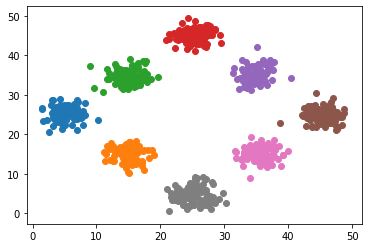

In [90]:
n_samps = 100

only_one = False

means = ( (np.array([[3,5], [4,4], [4,6], [5, 7], [6,6], [7,5], [6,4], [5,3]  ])  )*10 ) -25

if only_one:
    means = ( (np.array([[3,5] ])  )*10 ) -25


data = np.zeros((len(means)*n_samps,2))
y = np.zeros((len(means)*n_samps,1))
for ind, m in enumerate(means):
    samps = multivariate_normal(m, np.eye(2)*3).rvs(n_samps)#.astype(int)
    data[ind*n_samps:((ind+1)*n_samps)] = samps
    y[ind*n_samps:((ind+1)*n_samps)] = np.tile(ind, n_samps).reshape(-1,1)
    plt.scatter(samps[:,0], samps[:,1])

In [91]:
batch_size, sequence_length, vocab_size = 128, 2, 50

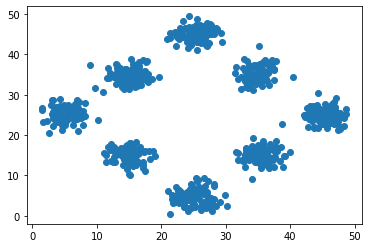

In [92]:
plt.scatter(data[:,0], data[:,1])

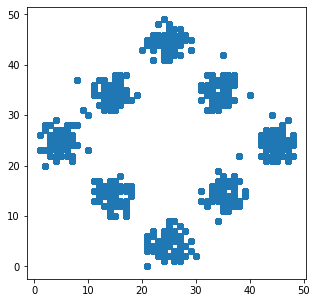

In [93]:
def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            if int(val) >= depth:
                val = depth-1
                #print(val)
            res[ind, j, :] = idd[int(val)]
            
    return res    

oh = one_hotter(data, vocab_size)

def torch_oh(input, vocab_size, axis=-1):
    input = input-input.min()
    x = input.flatten().unsqueeze(1).long()
    z = torch.zeros((input.shape[0]*input.shape[1], vocab_size ))
    z.scatter_(1,x,1)
    z = z.view(input.shape[0], input.shape[1], vocab_size)
    return z

def eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(data)), batch_size)
    return data[rand,:]

def oh_eightMixture_sample(batch_size):
    rand = np.random.choice(np.arange(len(oh)), batch_size)
    return oh[rand,:]
samps = oh_eightMixture_sample(10000).argmax(-1)
plt.figure(figsize=(5,5))
plt.scatter(samps[:,0], samps[:,1])


In [94]:
import os
os.chdir('../pytorch/nflib')

FileNotFoundError: [Errno 2] No such file or directory: '../pytorch/nflib'

In [95]:

import disc_utils
from MADE import *
from flows import *
from spline_flows import NSF_AR, NSF_CL
from TorchDiscCode import *

In [105]:
num_flows = 6
nh = 32
#batch_size= 64
#sequence_length = 2
#vocab_size = 35
vector_length = sequence_length*vocab_size
temperature = 0.1
flows = []
disc_layer_type = 'bipartite' #'autoreg' # 

In [106]:
for i in range(num_flows):
    # if want to also learn the scale: 
    # MADE(vocab_size, [nh, nh, nh], 2*vocab_size, num_masks=1, natural_ordering=False)
    if disc_layer_type == 'autoreg':
        layer = MADE(vocab_size, [nh, nh, nh], vocab_size, 
                     num_masks=1, natural_ordering=True)
        
        # if natural ordering is false then this only works for up to 4 layers!!!!
        
        disc_layer = DiscreteAutoregressiveFlow( layer, temperature, vocab_size )
    
    elif disc_layer_type == 'bipartite':
        layer = MLP(vector_length//2, vector_length//2, nh)
        
        disc_layer = DiscreteBipartiteFlow(layer, i%2, temperature, vocab_size, vector_length)
    flows.append(disc_layer)
    
model = DiscreteAutoFlowModel(flows)
    

In [107]:
rand_source = torch.distributions.normal.Normal(0,1)
rand_samps = rand_source.sample([sequence_length, vocab_size])

rand_samps.shape

torch.Size([2, 50])

torch.Size([128, 2])


(array([103.,   2.,   1.,   2.,   0.,  14.,   0.,   1.,   4.,   1.]),
 array([ 9. , 12.8, 16.6, 20.4, 24.2, 28. , 31.8, 35.6, 39.4, 43.2, 47. ]),
 <a list of 10 Patch objects>)

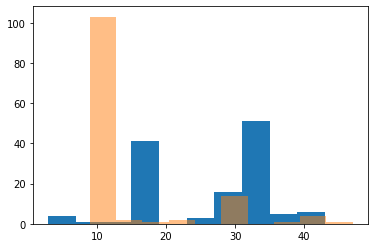

In [108]:
base = torch.distributions.OneHotCategorical(logits = rand_samps*3 )
samps = base.sample((batch_size,)).argmax(-1)
print(samps.shape)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

(10000, 2)


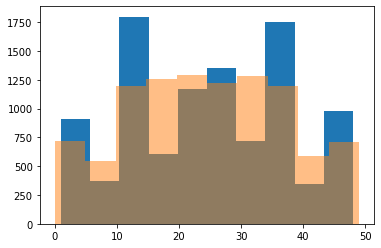

In [109]:
n_moon_samps = 10000
moon_samp = oh_eightMixture_sample(n_moon_samps).argmax(-1) +15
print(moon_samp.shape)
moon_samp = moon_samp
plt.hist(moon_samp[:,0])
#plt.show()
plt.hist(moon_samp[:,1], alpha=0.5)
plt.show()

(array([ 671.,  537., 1207., 1265., 1290., 1263., 1267., 1181.,  636.,
         683.]),
 array([ 0. ,  4.9,  9.8, 14.7, 19.6, 24.5, 29.4, 34.3, 39.2, 44.1, 49. ]),
 <a list of 10 Patch objects>)

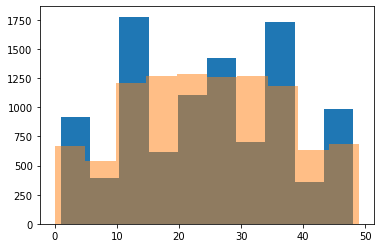

In [110]:
import collections
import pandas as pd
moon_dim0 = collections.Counter(moon_samp[:,0])
moon_dim1 = collections.Counter(moon_samp[:,1])
dim0_probs = np.zeros((vocab_size))
dim1_probs = np.zeros((vocab_size))
for k, v in moon_dim0.items():
    dim0_probs[k] = v/n_moon_samps
for k, v in moon_dim1.items():
    dim1_probs[k] = (v/n_moon_samps)

dim0_probs += 0.000001
dim1_probs += 0.000001

# need to renormalize again... 


dim0_probs = dim0_probs / np.sum(dim0_probs)
dim1_probs = dim1_probs / np.sum(dim1_probs)

moon_probs = np.vstack([dim0_probs, dim1_probs])

base = torch.distributions.OneHotCategorical(probs = torch.tensor(moon_probs).float() )
samps = base.sample((10000,)).argmax(-1)
plt.hist(samps[:,0])
plt.hist(samps[:,1], alpha=0.5)

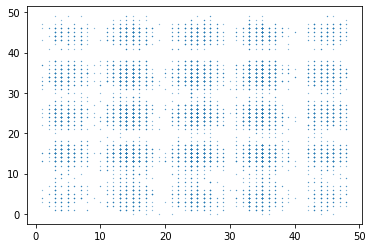

In [111]:
def plot2D(x, alpha=0.05):
    plt.scatter(x[:,0], x[:,1], alpha)
    plt.show()
    
plot2D(samps)

In [113]:
# test that invertibility is working!!!
ntests = 80
recorder = 0
for i in range(ntests):
    s = base.sample((batch_size,)).float().view(batch_size, -1)
    z = model.reverse(s)
    #z = model.reverse(z)
    prior_test = model.forward(z)
    #prior_test = model.forward(prior_test)
    #print(s[0],prior_test[0] )
    #print(s[0:10].argmax(-1))
    #print(prior_test[0:10].argmax(-1))
    if disc_layer_type == 'bipartite':
        if (s.argmax(-1) == prior_test.argmax(-1)).sum() == prior_test.shape[0]:
            recorder +=1
    else: 
        if (s.argmax(-1)[:,0] == prior_test.argmax(-1)[:,0]).sum() == prior_test.shape[0]:
            recorder +=1
    #print( (s == prior_test)[0])
    #print('------')
print('matched percentage', recorder / ntests)

matched percentage 1.0


In [114]:
s.shape

torch.Size([128, 100])

0 7.232274532318115
5 7.10564661026001
10 7.135790824890137
15 7.127670764923096
20 7.235661029815674
25 7.168910026550293
30 7.165674686431885
35 7.186387538909912
40 7.190084457397461
45 7.169408321380615
50 7.15826940536499
55 7.1921467781066895
60 7.189998626708984
65 7.15661096572876
70 7.1463541984558105
75 7.156141757965088
80 7.147336483001709
85 7.2053728103637695
90 7.175475597381592
95 7.160628795623779
100 7.157717227935791
105 7.14366340637207
110 7.098685264587402
115 7.193268299102783
120 7.157749652862549
125 7.142127990722656
130 7.256707191467285
135 7.1876220703125
140 7.203792095184326
145 7.127344131469727
150 7.1342034339904785
155 7.149407386779785
160 7.22287654876709
165 7.2355499267578125
170 7.231155872344971
175 7.244701862335205
180 7.179163932800293
185 7.264406204223633
190 7.153535842895508
195 7.192014217376709
200 7.193373203277588
205 7.220703125
210 7.196943759918213
215 7.151196002960205
220 7.187608242034912
225 7.168594837188721
230 7.220650196075

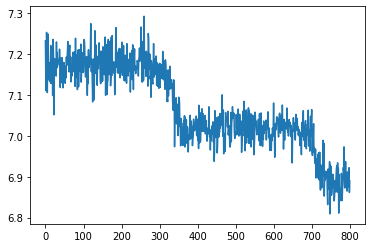

In [147]:
epochs = 800
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
weights = []
#x = torch.Tensor(data[:batch_size,:])
base_log_probs = torch.log(base.probs)
model.train()
for e in range(epochs):
    
    #x = d.sample(batch_size)
    #x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
    x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
    #print(x.shape)
    
    if disc_layer_type == 'bipartite':
        x= x.view(x.shape[0], -1)
    
    optimizer.zero_grad()
    zs = model.forward(x)
    
    if disc_layer_type == 'bipartite':
        zs = zs.view(batch_size, 2, -1)
    
    #print('shape of zs', zs.shape, zs)
    logprob = zs*base_log_probs.float()
    #print(logprob.shape)
    logprob = torch.sum(logprob, dim=2).sum(dim=1)
    #print(logprob.shape)
    
    loss = -torch.sum(logprob)/batch_size
    #loss = -torch.exp(logprob).sum()/batch_size
    
    loss.backward()
    optimizer.step()
    
    losses.append(loss.detach())
    
    if e%5==0:
        print(e, loss.item())
        #plotting the weights of a single layer: 
        
        flow_num = num_flows-1
        sub_part = 6
        w = model.flows[flow_num]._modules['layer'].net[sub_part]._parameters['weight'].detach().numpy()
        #print(w.shape)
        weights.append(w)
        #plt.hist(w[0,:],bins=100)
        #plt.show()
    
plt.plot(losses)
    

(128, 2)


(0, 50)

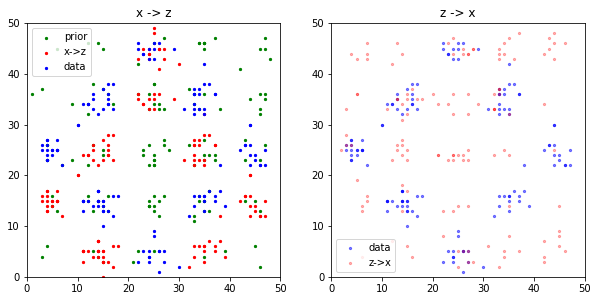

In [116]:
model.eval()

#x = d.sample(128)
x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
if disc_layer_type == 'bipartite':
    x = x.view(batch_size, -1)
zs = model.forward(x)
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(batch_size, 2, -1)
    x = x.view(batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((batch_size,)).argmax(-1)
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.scatter(x[:,0], x[:,1], c='b', s=5)
plt.legend(['prior', 'x->z', 'data'])
plt.axis('scaled')
plt.title('x -> z')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

if disc_layer_type == 'bipartite':
    z = model.reverse(base.sample((batch_size,)).float().view(batch_size, -1))
    z = z.view(batch_size, 2, -1)
else: 
    z = model.reverse(base.sample((batch_size,)).float())
z = z.detach().numpy().argmax(-1)
plt.subplot(122)
plt.scatter(x[:,0], x[:,1], c='b', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)
plt.legend(['data', 'z->x'])
plt.axis('scaled')
plt.title('z -> x')
plt.xlim([0,vocab_size])
plt.ylim([0,vocab_size])

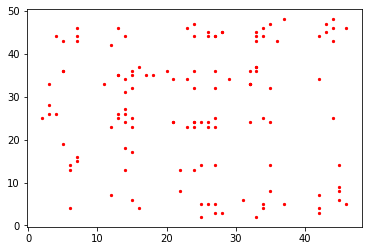

In [117]:
plt.scatter(z[:,0], z[:,1], c='r', s=5)
plt.show()

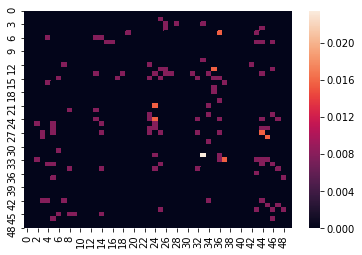

In [118]:
# heatmap of the data generated::::

dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ batch_size
import seaborn as sns;
sns.heatmap(heat)

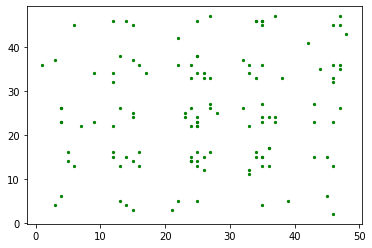

In [119]:
plt.scatter(p[:,0], p[:,1], c='g', s=5)
plt.show()

(1000, 2)


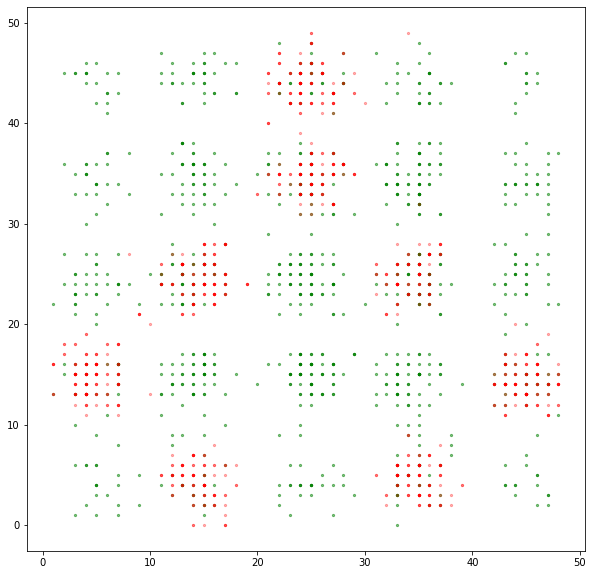

In [137]:
samp_batch_size = 1000
x = torch.tensor(oh_eightMixture_sample(samp_batch_size)).float()
if disc_layer_type == 'bipartite':
    x = x.view(samp_batch_size, -1)
zs = model.forward(x)
z = zs
if disc_layer_type == 'bipartite':
    z = z.view(samp_batch_size, 2, -1)
    x = x.view(samp_batch_size, 2, -1)

x = x.detach().numpy().argmax(-1)
z = z.detach().numpy().argmax(-1)
print(z.shape)
p = base.sample((samp_batch_size,)).argmax(-1)
plt.figure(figsize=(10,10))

plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.5)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.3)

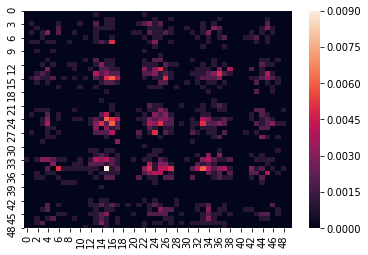

In [138]:
dim = base_log_probs.shape[-1]

heat = np.zeros((dim, dim))
for ind, ex in enumerate(p): 
    heat[ex[0], ex[1] ] += 1

heat = heat/ samp_batch_size
import seaborn as sns;
sns.heatmap(heat)

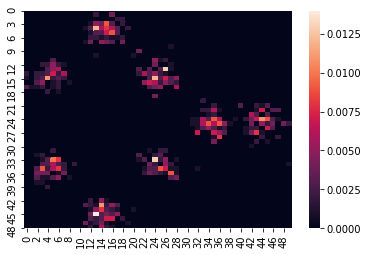

In [139]:

# generated z's. 
heat = np.zeros((dim, dim))
for ind, ex in enumerate(z): 
    heat[ex[0], ex[1] ] += 1
heat = heat/ samp_batch_size
import seaborn as sns;
sns.heatmap(heat)

In [140]:
def one_hotter(x, depth):
    idd = np.eye(depth)
    #print(idd[0])
    res = np.zeros((x.shape[0], x.shape[1], depth))
    #print(res.shape)
    for ind in range(len(x)): 
        for j, val in enumerate(x[ind]):
            if int(val) >= depth:
                val = depth-1
                #print(val)
            res[ind, j, :] = idd[int(val)]
            
    return res    

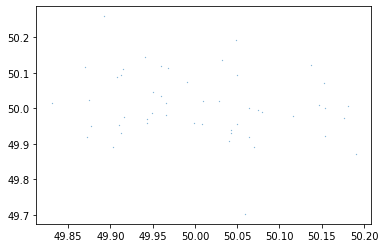

In [141]:

d = np.vstack( [np.random.normal(50,0.1,dim), np.random.normal(50,0.1,dim)]).T
plot2D(d)
d = one_hotter( d ,dim)

In [142]:
samps.shape

torch.Size([32, 2, 50])

In [143]:
base_log_probs.shape

torch.Size([2, 50])

In [144]:
res= []
b_size = 32
for i in range(100):
    samps = torch.tensor(d).float()
    logprob = samps*base_log_probs
    
    logprob = torch.sum(logprob, dim=2).sum(dim=1)
    #print(logprob.shape)
    #loss = -torch.exp(logprob).sum()/samps.shape[0]
    loss = -torch.sum(logprob)
    res.append(loss)
    
np.mean(np.asarray(res))

1023.0109

In [145]:
x = torch.tensor(oh_eightMixture_sample(batch_size)).float()
#print(x.shape)
x= x.view(x.shape[0], -1)

optimizer.zero_grad()
zs = model.forward(x)
zs = zs.view(batch_size, 2, -1)
#print('shape of zs', zs.shape, zs)
logprob = zs*base_log_probs.float()

In [146]:
res= []
b_size = 32
for i in range(100):
    samps = base.sample((b_size,)).float()
    logprob = samps*base_log_probs
    
    logprob = torch.sum(logprob, dim=2).sum(dim=1)
    #print(logprob.shape)
    loss = -torch.sum(logprob)/ batch_size
    #loss = -torch.exp(logprob).sum()/b_size
    
    res.append(loss)
    
np.mean(np.asarray(res))

1.7690922

Text(0.5, 1.0, 'Distribution of optimal scores')

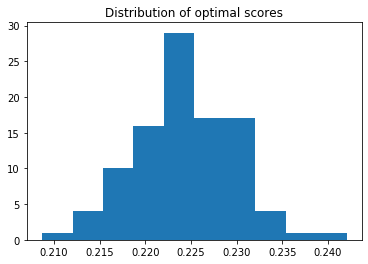

In [136]:
plt.hist(res)
plt.title('Distribution of optimal scores')

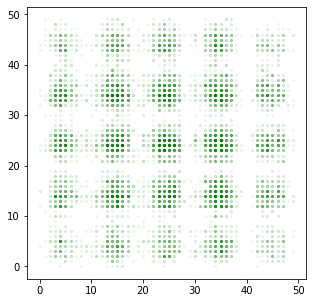

In [48]:
p = base.sample((10000,)).argmax(-1)
plt.figure(figsize=(5,5))

plt.scatter(p[:,0], p[:,1], c='g', s=5, alpha=0.05)

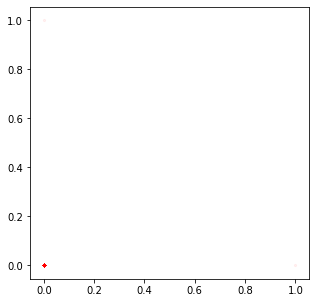

In [49]:
nsamps = 1000
plt.figure(figsize=(5,5))
if disc_layer_type == 'bipartite':
    z = model.reverse(base.sample((nsamps,)).float().view(nsamps, -1)).detach().numpy()
else: 
    print('autoreg')
    z = model.reverse(base.sample((nsamps,)).float()).detach().numpy()
    z = z.argmax(-1)
plt.scatter(z[:,0], z[:,1], c='r', s=5, alpha=0.05)

In [187]:
z.shape

(1000, 2, 100)

## Checking how block insertion works

In [150]:
s = np.random.randint(0,10, (50,6))
s0 = s[:,::2]
s1 = s[:,1::2]
#print(s, s0)
np.concatenate([s0,s1], 1);

In [151]:
AffineHalfFlow( 6, False)

AffineHalfFlow(
  (s_cond): MLP(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=24, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=24, out_features=24, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=24, out_features=24, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=24, out_features=3, bias=True)
    )
  )
  (t_cond): MLP(
    (net): Sequential(
      (0): Linear(in_features=3, out_features=24, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
      (2): Linear(in_features=24, out_features=24, bias=True)
      (3): LeakyReLU(negative_slope=0.2)
      (4): Linear(in_features=24, out_features=24, bias=True)
      (5): LeakyReLU(negative_slope=0.2)
      (6): Linear(in_features=24, out_features=3, bias=True)
    )
  )
)

In [66]:
layers = [AffineHalfFlow( 6, False), AffineHalfFlow( 6, True)]
f = s
for l in layers: 
    f = lol.reverse(torch.tensor(f).float())[0]
b = f
for l in layers: 
    b = lol.reverse(torch.tensor(b).float())[0]


/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.
/Users/trentonbricken/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


In [223]:
base = torch.distributions.multivariate_normal.MultivariateNormal(torch.zeros(10), torch.eye(10))

flows = [AffineHalfFlow(dim=10, parity=i%2, nh=24 ,
                        scale=False, block_mask=False) for i in range(4)]
flows.append(AffineConstantFlow(dim=10, shift=False))
network = NormalizingFlowModel(base, flows)
   

In [224]:
s = network.sample()
s.shape

torch.Size([10000, 10])

In [225]:
s = torch.tensor(np.random.randint(0,10, (50,10))).float()

In [226]:
s[0:2]

tensor([[0., 3., 6., 9., 6., 1., 5., 4., 9., 4.],
        [5., 4., 3., 5., 6., 2., 1., 0., 2., 2.]])

In [227]:
f = network.forward(s)[0]


In [228]:
f[0:2]

tensor([[ 0.3711,  2.0053,  1.2576,  3.8458, 13.5337,  0.6626,  5.6304, 21.8273,
         13.9251,  0.5547],
        [ 4.0072,  2.8304,  0.6248,  2.1776, 13.9554,  0.9793,  0.8463, -1.6907,
          2.7597,  0.2816]], grad_fn=<SliceBackward>)

In [229]:
b = network.backward(f)[0]

In [230]:
b[0:2]

tensor([[-2.9802e-08,  3.0000e+00,  6.0000e+00,  9.0000e+00,  6.0000e+00,
          1.0000e+00,  5.0000e+00,  4.0000e+00,  9.0000e+00,  4.0000e+00],
        [ 5.0000e+00,  4.0000e+00,  3.0000e+00,  5.0000e+00,  6.0000e+00,
          2.0000e+00,  1.0000e+00,  0.0000e+00,  2.0000e+00,  2.0000e+00]],
       grad_fn=<SliceBackward>)

In [206]:
s == b

tensor([[False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, False, False, False, False, False, False],
        [False, False, False, False, Fal

In [67]:
s == b.detach().numpy()

array([[ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, False, False, False],
       [ True, False, False, Fa

In [174]:
ins = torch.arange( 3) 
to = torch.zeros((20,6))
to[:,::2] = ins
to

tensor([[0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.],
        [0., 0., 1., 0., 2., 0.]])